In [1]:
from ConicalSpeaker import *
%matplotlib inline

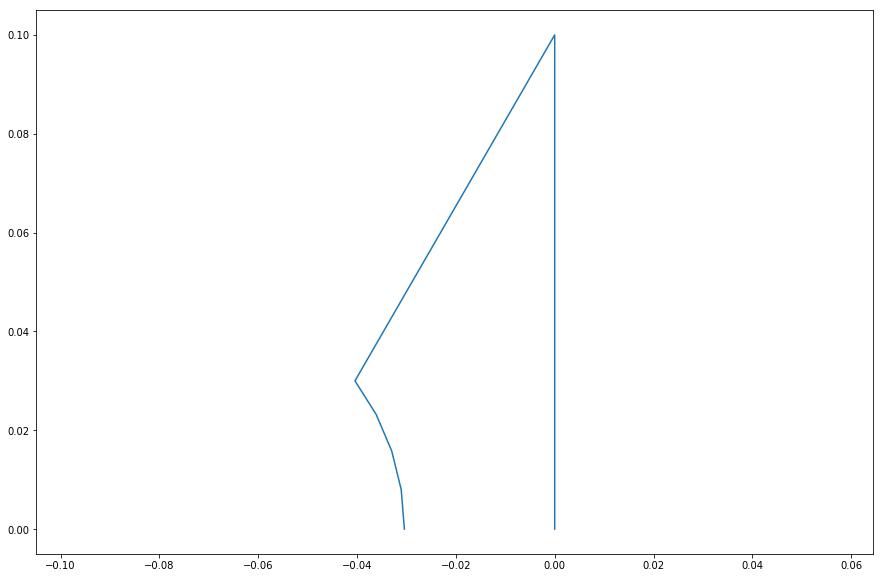

In [2]:
# 15 Inch ~ 38cm -> 19cm cone radius
# 30 degree cone angle
# 8cm dust cap -> 4cm dust cap radius
# 2cm dust cap height
s = ConicalSpeaker('8 inch Woofer', 0.10, 30.0, 0.03, 0.01)
s.plotConeSection()

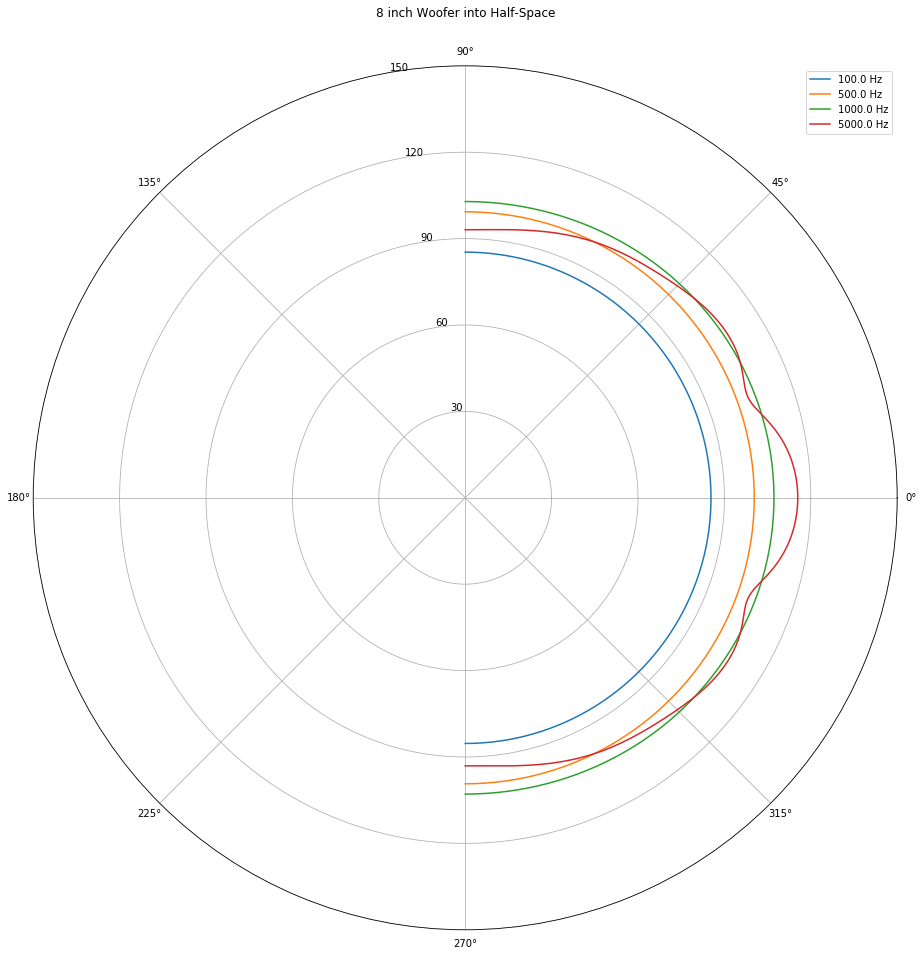

In [3]:
aFrequency = np.array([100, 500, 1000, 5000], dtype=np.float32)
s.makePolarPlot(aFrequency)

CPU times: user 690 ms, sys: 48 ms, total: 738 ms
Wall time: 2min 19s


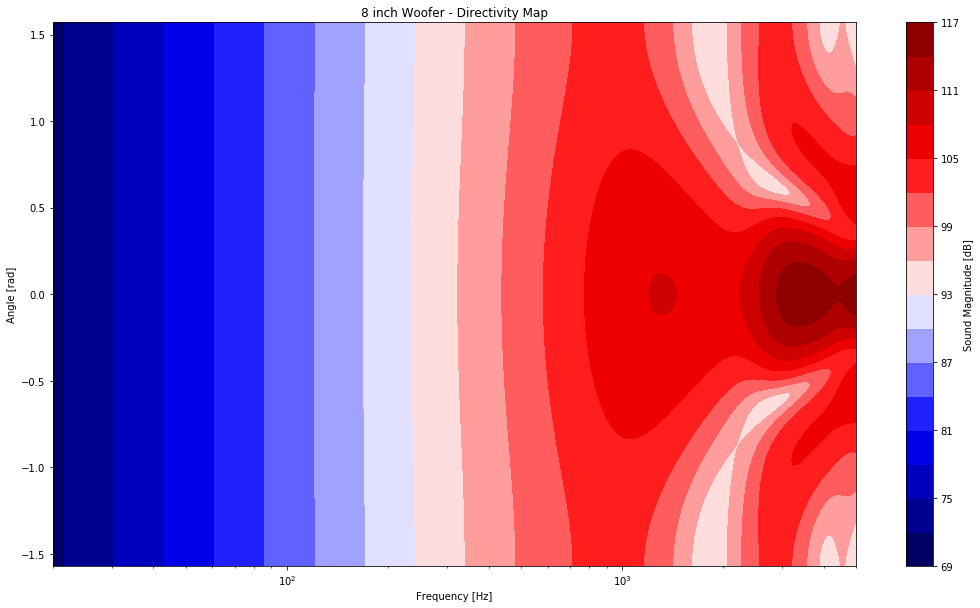

In [4]:
%%time
s.makePolarMap()

CPU times: user 465 ms, sys: 138 ms, total: 603 ms
Wall time: 1min 58s


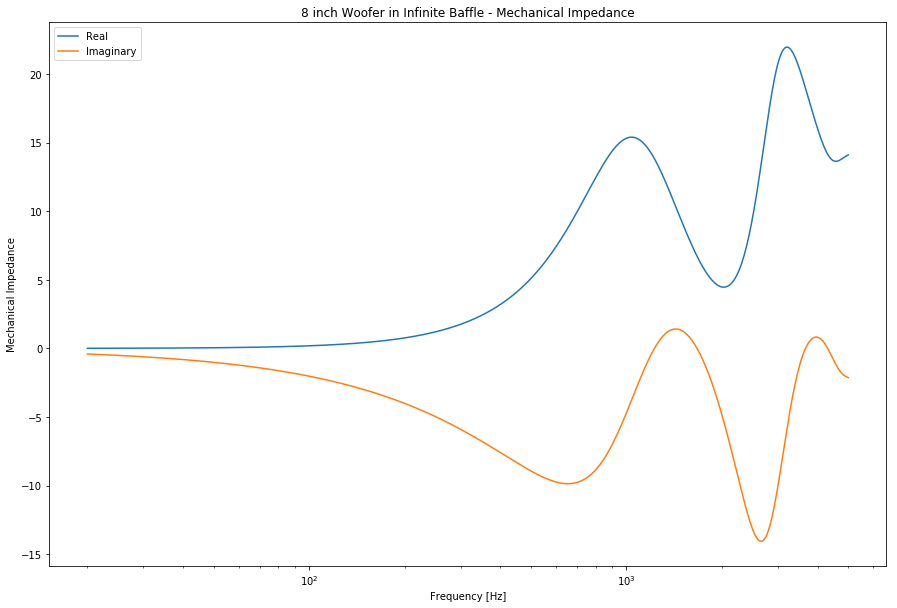

In [5]:
%%time
s.makeImpedancePlot()